In [1]:
# Enable automatic import reloading
%load_ext autoreload
%autoreload 2

# Display outputs from all lines when they exist
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "last"

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import pickle
import pandas as pd
import seaborn as sns

import triadicsim


In [9]:
def get_filename(graph_type, closure_method, experiment_type, value, ):
    if experiment_type == 'threshold':
        value = "{:.1f}".format(value)
    return f'e1_hyperparam/{graph_type}_model{closure_method}_{experiment_type}{value}.pkl'

def filter_df(df, filter_d):
    for k, v in filter_d.items():
        df = df[df[k] == v]
    return df

Constants

In [14]:
graph_type = "gnp"
closure_methods= ['pop', 'static', 'random', 'max', ]
experiment_types = ['closure', 'threshold']
threshold_vals = np.arange(0.1, 1, 0.1)
closure_vals = [1, 5, 10, 15, 20, 25]
experiment_vals_d = {'closure': closure_vals,
                     'threshold':threshold_vals,
                    }
all_data = pd.DataFrame(columns=['max_size_rounds', 'rounds_filled', 'max_sizes', 'graph_type', 'closure_method', 'experiment_type', 'values'])
colors = [sns.xkcd_rgb['light red'], sns.xkcd_rgb['greenish'], sns.xkcd_rgb['denim'], sns.xkcd_rgb['purpleish blue'], sns.xkcd_rgb['bubblegum']]

## Read in data

In [23]:
for experiment_type in experiment_types:
    experiment_vals = experiment_vals_d[experiment_type]
    for i, closure_method in enumerate(closure_methods):

        all_max_size_rounds = []
        for experiment_val in experiment_vals:
            filename = get_filename(graph_type, closure_method, experiment_type, experiment_val)
            (sim_log, rounds_filled, rounds_frozen, max_size_round, sizes_round) = pickle.load(
                open(filename, 'rb')
            )
            all_max_size_rounds.append(max_size_round)

            vals = {
                'max_size_rounds': np.array(max_size_round),
                'rounds_filled': np.array(rounds_filled),
                'max_sizes': np.array([max(x) for x in sizes_round]),
                'graph_type': graph_type,
                'closure_method': closure_method, 
                'experiment_type': experiment_type, 
                'values': experiment_val
            }
            all_data = all_data.append(vals, ignore_index=True)



In [24]:
df = filter_df(all_data, {
    'graph_type': graph_type,
    'closure_method': closure_method, 
    'experiment_type': "closure",})
df.head()

,max_size_rounds,rounds_filled,max_sizes,graph_type,closure_method,experiment_type,values
18,"[28, 20, 4, 17, 100, 16, 3, 12, 3, 13, 22, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0.97, 0.97, 0.13, 0.2, 0.7, 0.97, 0.07, 0.39,...",gnp,max,closure,1
19,"[51, 16, 21, 7, 21, 15, 14, 2, 52, 15, 16, 1, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...","[0.99, 1.0, 1.0, 1.0, 0.98, 0.98, 0.99, 0.07, ...",gnp,max,closure,5
20,"[81, 17, 29, 23, 85, 90, 53, 14, 12, 36, 100, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[0.09, 1.0, 1.0, 0.96, 0.13, 0.3, 0.2, 0.18, 0...",gnp,max,closure,10
21,"[18, 17, 51, 17, 26, 62, 100, 11, 83, 28, 38, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.97, 0.99, 0.95, 1.0, 1.0, 0.99, 0.56, 0.99,...",gnp,max,closure,15
22,"[27, 18, 18, 30, 10, 37, 60, 36, 28, 14, 38, 2...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1.0, 1.0, 1.0, 0.99, 1.0, 0.07, 0.99, 0.99, 0...",gnp,max,closure,20


## Plotting

/var/folders/cg/yfyy6nkx6jd8r_wqrhbygzkh0000gn/T/ipykernel_60763/2363630526.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(x) for x in closure_vals]);


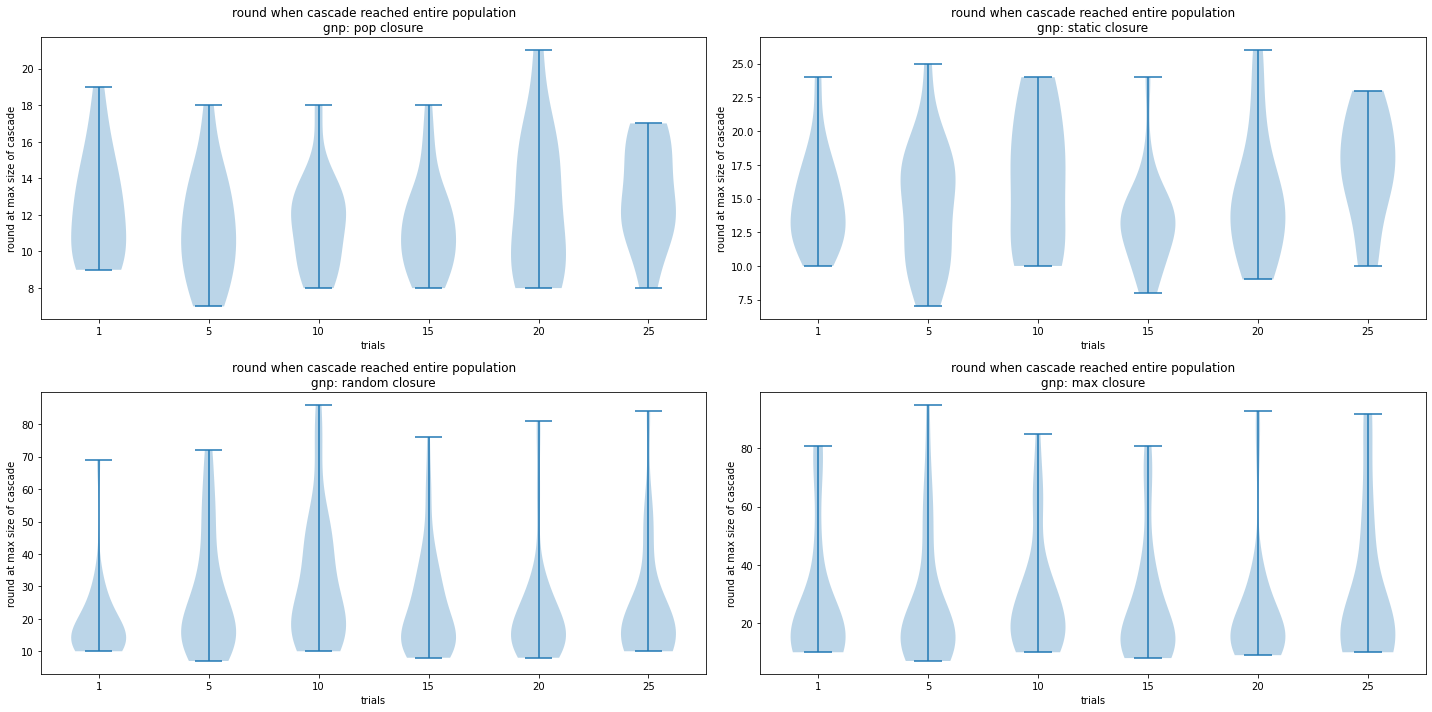

In [25]:
f, axs = plt.subplots(2, 2, figsize=(20, 10))
PLOT_TYPE= 'violin' # 'hist', 'violin', 'box'

for i, closure_method in enumerate(closure_methods):
    ax = axs[i//2, i%2]
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': "closure"})
    
    if PLOT_TYPE != 'hist':
        all_round_when_complete = []
    for i, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        if PLOT_TYPE == 'hist':
            ax.hist(round_when_complete, label=row['values'], alpha=0.5);
        else:
            all_round_when_complete.append(round_when_complete)
    if PLOT_TYPE == 'violin':
        ax.violinplot(all_round_when_complete)
    elif PLOT_TYPE == 'box':
        ax.boxplot(all_round_when_complete)
        
    if PLOT_TYPE == 'hist':
        ax.legend(loc='upper right');
        ax.set_xlabel('round at max size of cascade');
        ax.set_ylabel('trials');

    elif PLOT_TYPE == 'violin':
        ax.set_xticklabels([''] + [str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
    elif PLOT_TYPE == 'box':
        ax.set_xticklabels([str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
        
    ax.set_ylabel('round at max size of cascade');
    ax.set_xlabel('trials');
    ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();


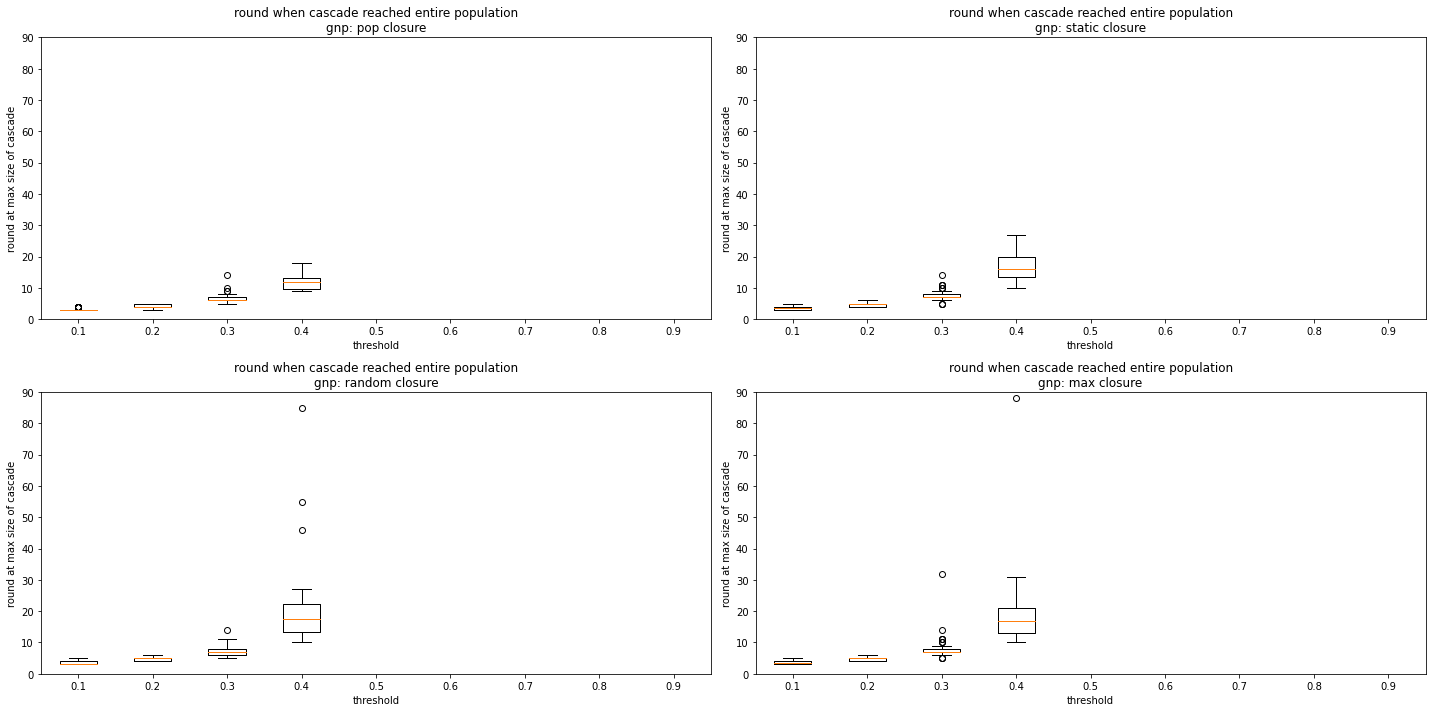

In [42]:
f, axs = plt.subplots(2, 2, figsize=(20, 10))
PLOT_TYPE= 'box' # 'hist', 'violin', 'box'
experiment_type = 'threshold'

for i, closure_method in enumerate(closure_methods):
    ax = axs[i//2, i%2]
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': experiment_type })
    
    if PLOT_TYPE != 'hist':
        all_round_when_complete = []
    for i, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        if PLOT_TYPE == 'hist':
            ax.hist(round_when_complete, label="{:0.1f}".format(row['values']), alpha=0.5);
        else:
            all_round_when_complete.append(round_when_complete)
    if PLOT_TYPE == 'violin':
        ax.violinplot(all_round_when_complete)
    elif PLOT_TYPE == 'box':
        ax.boxplot(all_round_when_complete)
        
    if PLOT_TYPE == 'hist':
        ax.legend(loc='upper right');
        ax.set_xlabel('threshold');
        ax.set_ylabel('trials');
    elif PLOT_TYPE == 'violin':
        ax.set_xticklabels([''] + ["{:0.1f}".format(x) for x in experimet_vals_d[experiment_type]]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('threshold');
        ax.set_ylim([0, 90])
    elif PLOT_TYPE == 'box':
        ax.set_xticklabels(["{:0.1f}".format(x) for x in experiment_vals_d[experiment_type]]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('threshold');
        ax.set_ylim([0, 90])
        
    ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();


In [59]:
def box_plot(ax, data, edge_color, label):
    bp = ax.boxplot(data, patch_artist=True, label=label)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    # for patch in bp['boxes']:
        # patch.set(facecolor=fill_color)       
        
    return bp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


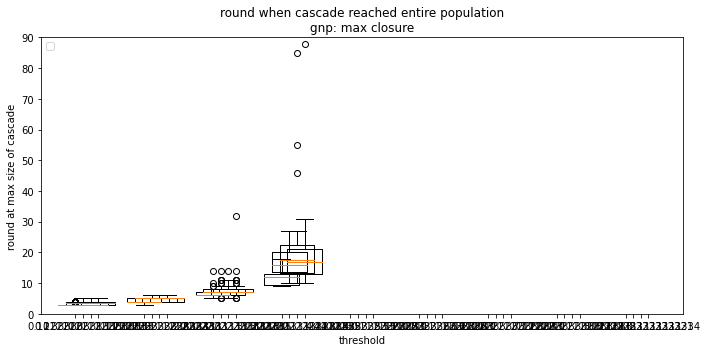

In [75]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
experiment_type = 'threshold'
experiment_vals = experiment_vals_d[experiment_type]
for i, closure_method in enumerate(closure_methods):
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': experiment_type })
    
    all_round_when_complete = []
    for _, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        all_round_when_complete.append(round_when_complete)
    ax.boxplot(all_round_when_complete, positions=np.arange(0+i/len(experiment_vals), len(experiment_vals) + i/len(experiment_vals), 1))
    # box_plot(ax, all_round_when_complete, colors[i], closure_method)
        
ax.legend(loc='upper left');
# ax.set_xticklabels(["{:0.1f}".format(x) for x in experiment_vals_d[experiment_type]]);
ax.set_ylabel('round at max size of cascade');
ax.set_xlabel('threshold');
ax.set_ylim([0, 90])
        
ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();
